In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# read prices from csv file
prices = pd.read_csv('final_data_norm.csv',)

In [14]:
prices['Timestamp']=pd.to_datetime(prices['Timestamp'])

In [20]:
prices.set_index('Timestamp',drop=True,inplace=True)

In [21]:
prices.head()

,Instr1,Instr2,Instr3,Instr4,Instr5,Instr6,Instr7,Instr8,Instr9,Instr10,Instr11,Instr12,Instr13,Instr14,Instr15,Instr16,Instr17,Instr18,Instr19,Instr20
Timestamp,,,,,,,,,,,,,,,,,,,,
2016-03-11,-1.416659,-1.420558,-1.426727,-1.426903,-1.424853,-1.421595,-1.414042,-1.403588,-1.393133,-1.382952,-1.372094,-1.360408,-1.351622,-1.343384,-1.333519,-1.325976,-1.319087,-1.313109,-1.309208,-1.306107
2016-03-14,-1.462301,-1.472009,-1.482483,-1.486425,-1.485694,-1.483600,-1.477712,-1.468183,-1.459244,-1.449825,-1.439647,-1.429297,-1.421079,-1.414141,-1.405593,-1.398603,-1.393041,-1.387593,-1.384227,-1.381651
2016-03-15,-1.504228,-1.514607,-1.527892,-1.535233,-1.535472,-1.533584,-1.527089,-1.517461,-1.508316,-1.499284,-1.488712,-1.477881,-1.469107,-1.461563,-1.452365,-1.444678,-1.438367,-1.432122,-1.427919,-1.425299
2016-03-16,-1.419844,-1.426643,-1.440522,-1.448331,-1.447591,-1.444372,-1.437431,-1.428227,-1.419032,-1.410119,-1.399115,-1.387963,-1.378961,-1.370482,-1.361888,-1.354871,-1.348509,-1.342255,-1.338886,-1.336325
2016-03-17,-1.355626,-1.360255,-1.373846,-1.382261,-1.383064,-1.381734,-1.377009,-1.370292,-1.363145,-1.355088,-1.345784,-1.335752,-1.327977,-1.320802,-1.312817,-1.306453,-1.301592,-1.296917,-1.294369,-1.292677


In [22]:
cumret = np.log(abs(prices)).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True) 

In [23]:
def calculate_distances(cumret):
    '''
    calculate Euclidean distance for each pair of stocks in the dataframe
    return sorted dictionary (in ascending order)
    '''
    distances = {} # dictionary with distance for each pair
    
    # calculate distances
    for s1 in cumret.columns:
        for s2 in cumret.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in distances.keys()) and (f'{s2}-{s1}' not in distances.keys()):
                dist = np.sqrt(np.sum((cumret[s1] - cumret[s2])**2)) # Euclidean distance
                distances[f'{s1}-{s2}'] = dist
    
    # sort dictionary
    sorted_distances = {k:v for k,v in sorted(distances.items(), key = lambda item: item[1])}
    
    return sorted_distances

def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]
    
    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint
    
    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]
    
    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]
    
    return halflife

def calculate_metrics(sorted_distances, cumret, N=5):
    '''
    calculate metrics for N pairs with the smallest Euclidean distance
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    
    pairs = [k for k,v in sorted_distances.items()][:N]
    
    cols = ['Euclidean distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread = cumret[s1] - cumret[s2]
        results.loc[pair]['Euclidean distance'] = np.sqrt(np.sum((spread)**2))
        results.loc[pair]['CADF p-value'] = cadf_pvalue(s1, s2, cumret)
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        results.loc[pair]['Spread SD'] = spread.std()
        results.loc[pair]['Num zero-crossings'] = ((spread[1:].values * spread[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within 2-SD band'] = (abs(spread) < 2*spread.std()).sum() / len(spread) * 100
        
    return results

def plot_pairs(sorted_distances, cumret_train, cumret_test, N=5):
    '''
    plot cumulative returns of the spread for each of N pairs with smallest Euclidean distance
    '''
    pairs = [k for k,v in sorted_distances.items()][:N]
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread_train = cumret_train[s1] - cumret_train[s2]
        spread_test = cumret_test[s1] - cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

In [24]:
# prepare data
cumret12_6 = cumret.loc['2016-11-03':]
cumret12_6 = cumret12_6 / cumret12_6.iloc[0] # divide by first row so that all prices start at 1
train12_6 = cumret12_6.loc['2016-11-03':'2020-01-24']
test12_6 = cumret12_6.loc['2020-01-24':'2023-12-06'] 

In [25]:
# calculate Euclidean distances for each pair
sorted_distances12_6 = calculate_distances(train12_6)

In [26]:
# print top 10 pairs with smallest distance
[[k,v] for k,v in sorted_distances12_6.items()][:10]

[['Instr13-Instr14', 5.057661848163837],
 ['Instr16-Instr17', 5.86854994147567],
 ['Instr10-Instr11', 6.128321989464219],
 ['Instr12-Instr13', 6.196635157530377],
 ['Instr11-Instr12', 6.307295550493056],
 ['Instr15-Instr16', 6.726637598831843],
 ['Instr14-Instr15', 7.723951931240917],
 ['Instr7-Instr8', 8.903972278536699],
 ['Instr10-Instr12', 8.917411355880272],
 ['Instr11-Instr13', 9.158744918361332]]

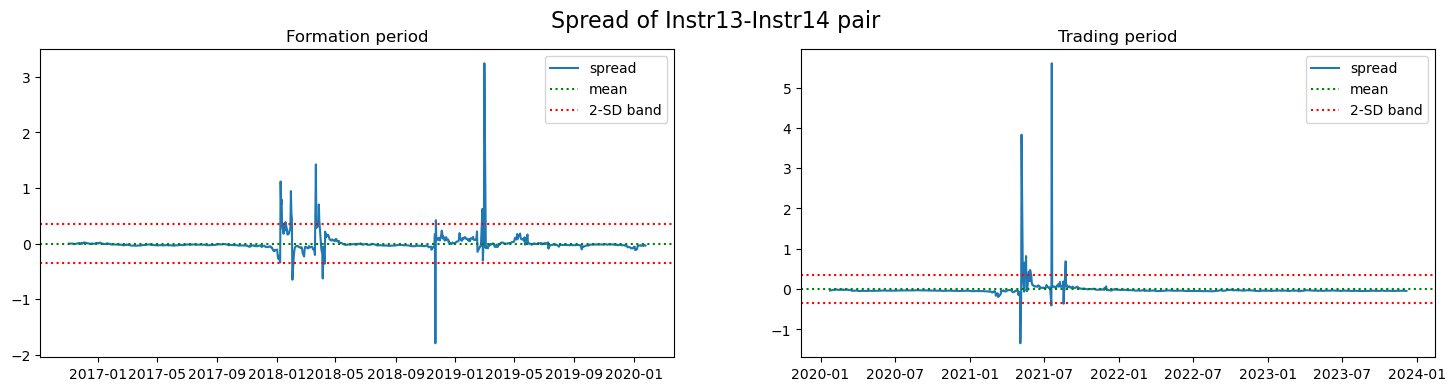

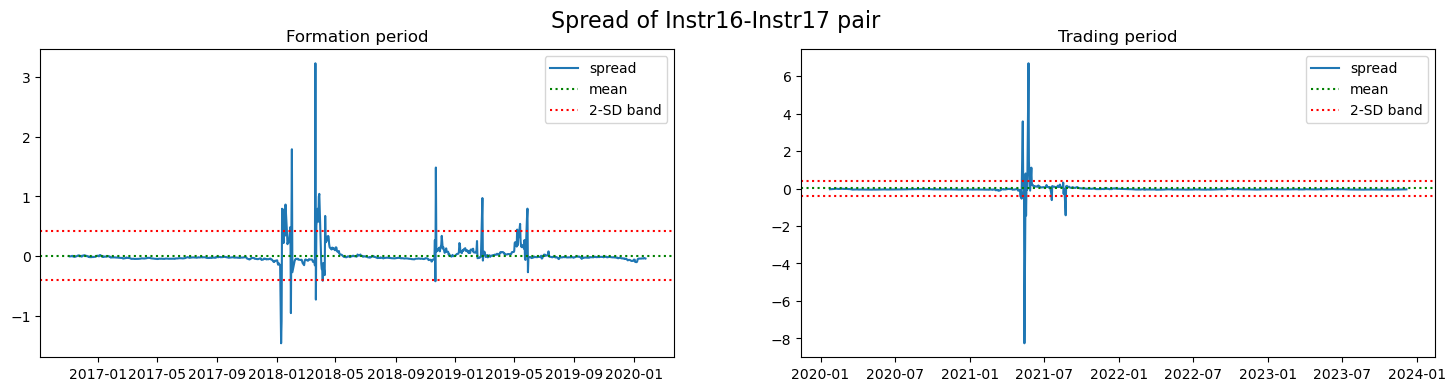

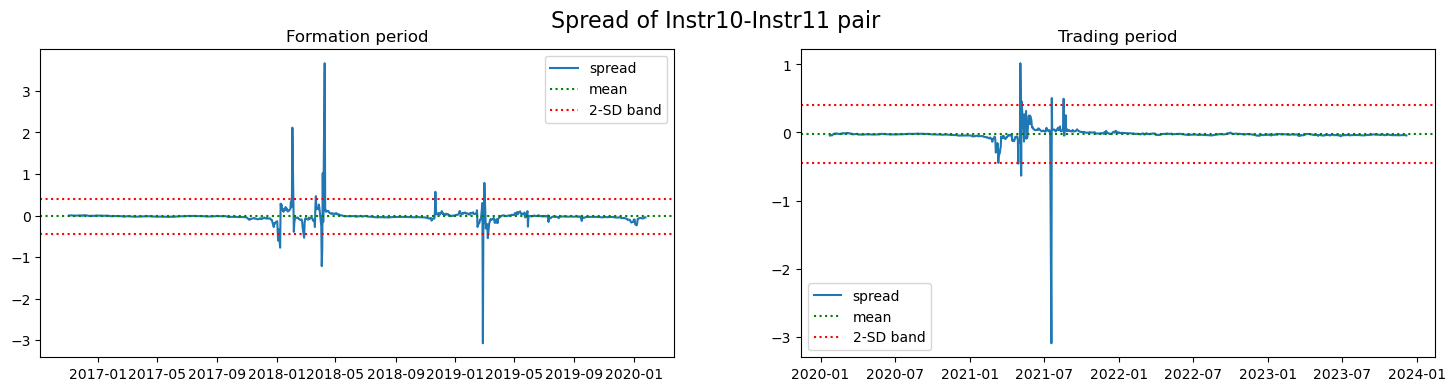

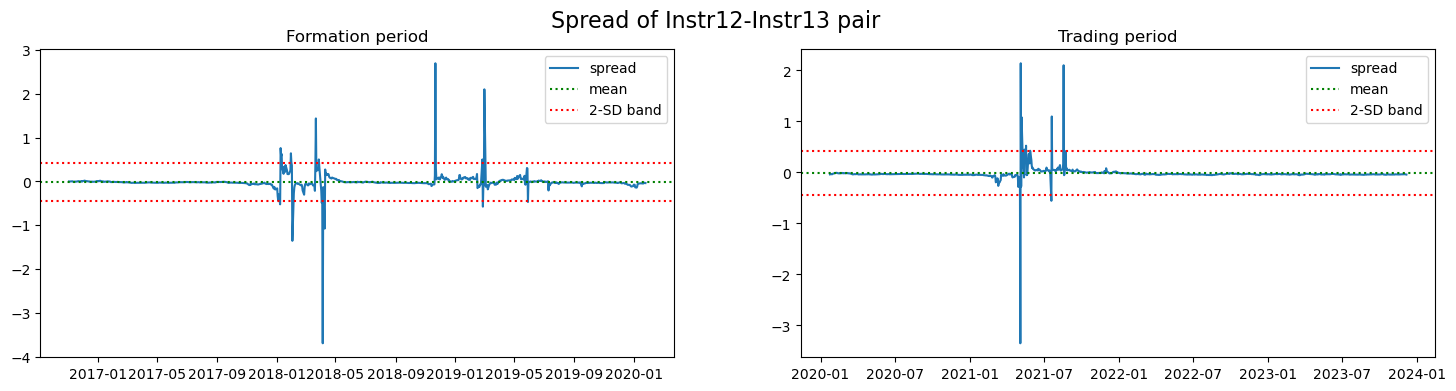

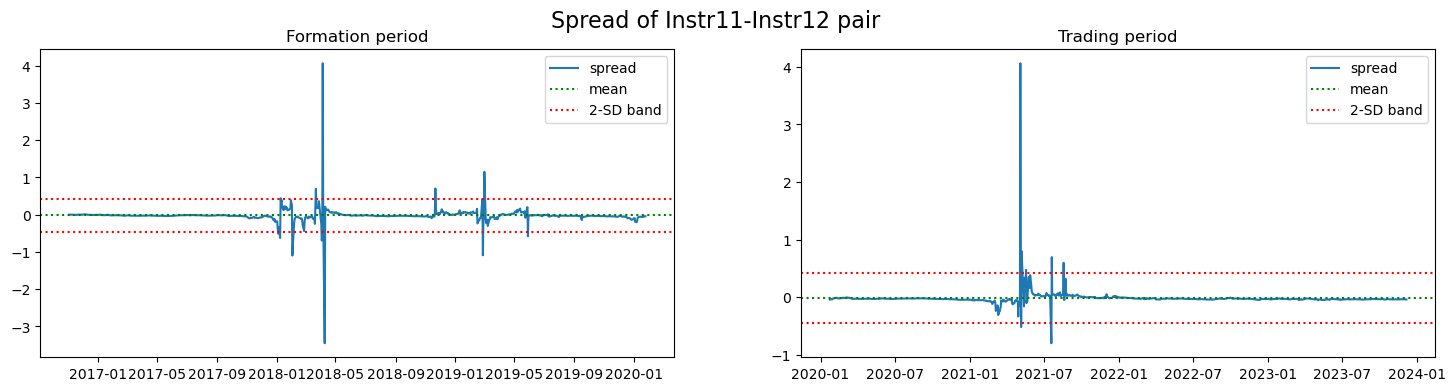

In [27]:
plot_pairs(sorted_distances12_6, train12_6, test12_6)

In [28]:
calculate_metrics(sorted_distances12_6, train12_6)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
Instr13-Instr14,5.057662,0.0,0.0,0.175447,56,0.403048,0.853875,97.596154
Instr16-Instr17,5.86855,0.000001,0.0,0.203372,54,0.36155,0.814825,96.754808
Instr10-Instr11,6.128322,0.000001,0.0,0.211342,40,0.399002,0.751099,98.4375
Instr12-Instr13,6.196635,0.0,0.0,0.21468,38,0.43591,0.866241,97.836538
Instr11-Instr12,6.307296,0.0,0.0,0.217755,36,0.417352,0.702028,98.317308


In [29]:
calculate_metrics(sorted_distances12_6, test12_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
Instr13-Instr14,7.323764,0.0,0.0,0.230962,18,0.388102,0.733533,99.2
Instr16-Instr17,11.787452,0.0,0.0,0.371562,24,0.44653,0.72009,99.1
Instr10-Instr11,3.855939,0.0,0.0,0.118987,28,0.40016,0.683825,98.3
Instr12-Instr13,5.119545,0.000001,0.000346,0.160464,26,0.379024,0.565157,98.8
Instr11-Instr12,4.772735,0.000004,0.000012,0.149802,22,0.40965,0.837104,98.4


In [31]:
# prepare data
cumret24_6 = cumret.loc['2016-11-03':]
cumret24_6 = cumret24_6 / cumret24_6.iloc[0] # divide by first row so that all prices start at 1
train24_6 = cumret24_6.loc['2016-11-03':'2020-01-24'] # formation period
test24_6 = cumret24_6.loc['2020-01-24':'2023-12-06'] # trading period

In [32]:
# calculate Euclidean distances for each pair
sorted_distances24_6 = calculate_distances(train24_6)

In [33]:
# print top 10 pairs with smallest distance
[[k,v] for k,v in sorted_distances24_6.items()][:10]

[['Instr13-Instr14', 5.057661848163837],
 ['Instr16-Instr17', 5.86854994147567],
 ['Instr10-Instr11', 6.128321989464219],
 ['Instr12-Instr13', 6.196635157530377],
 ['Instr11-Instr12', 6.307295550493056],
 ['Instr15-Instr16', 6.726637598831843],
 ['Instr14-Instr15', 7.723951931240917],
 ['Instr7-Instr8', 8.903972278536699],
 ['Instr10-Instr12', 8.917411355880272],
 ['Instr11-Instr13', 9.158744918361332]]

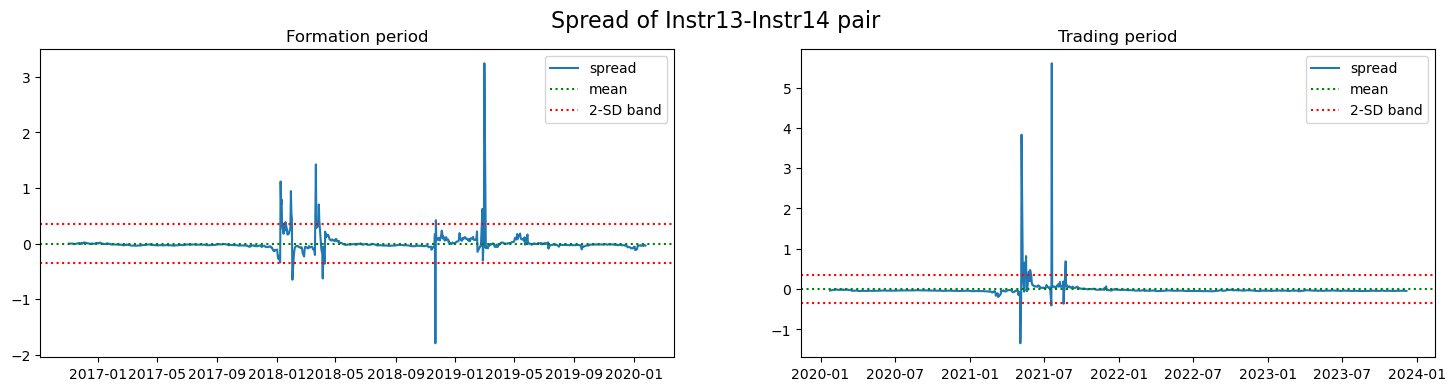

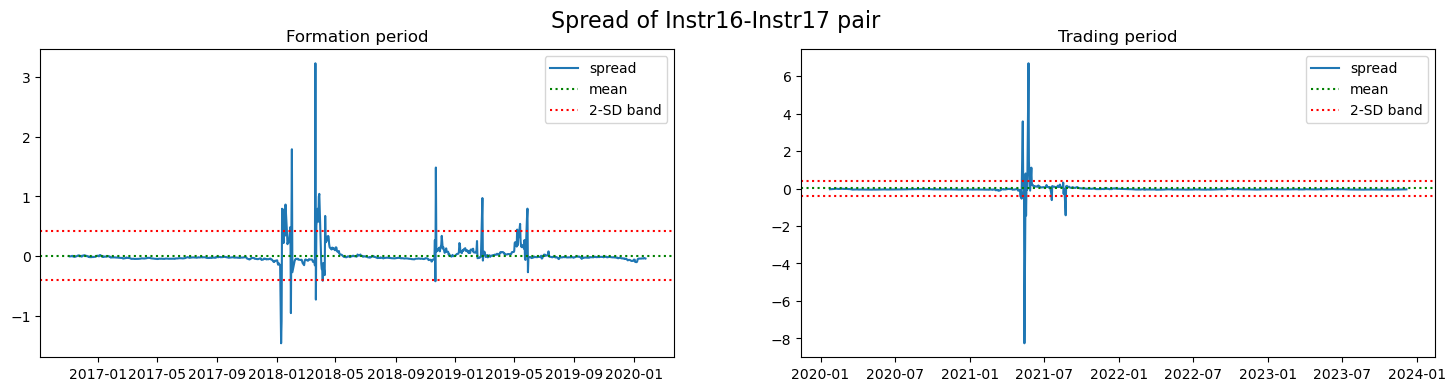

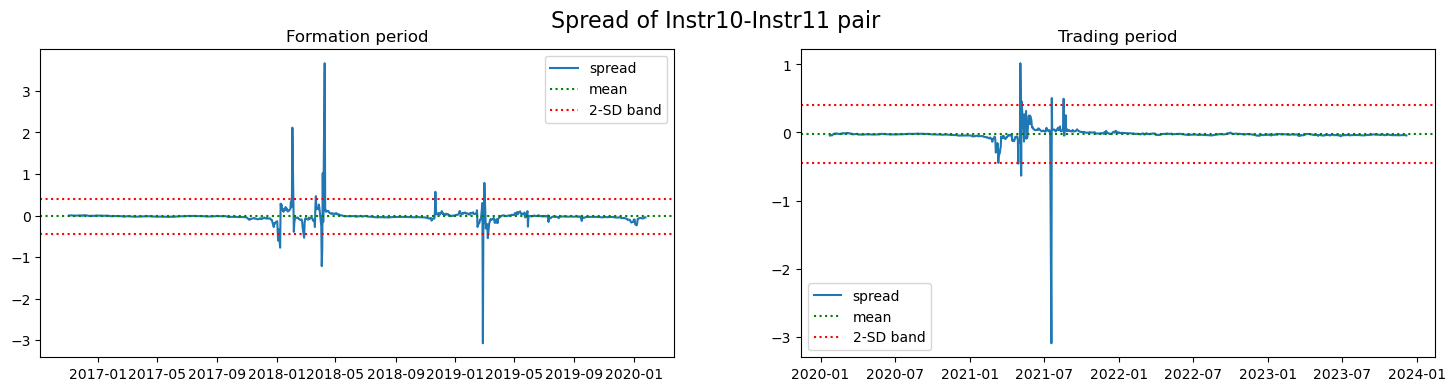

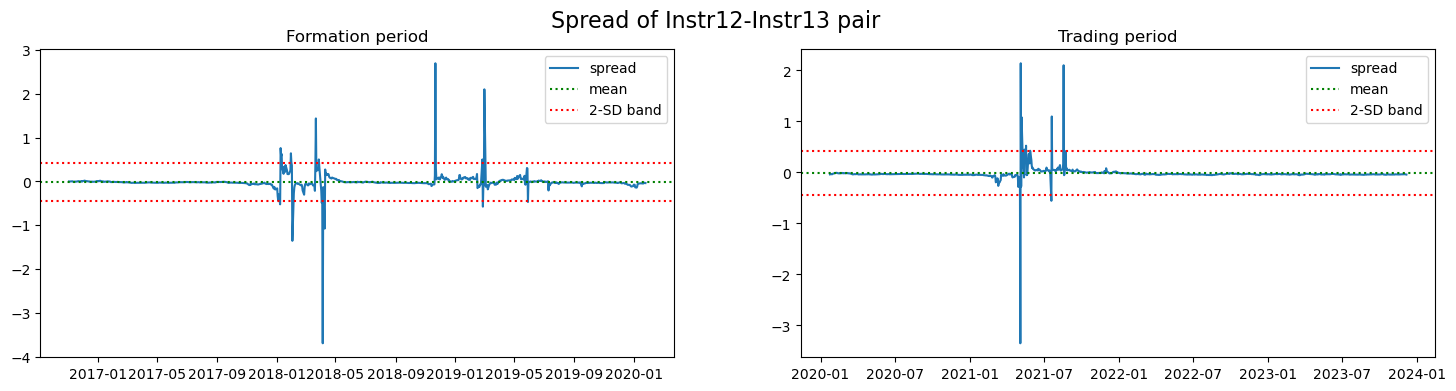

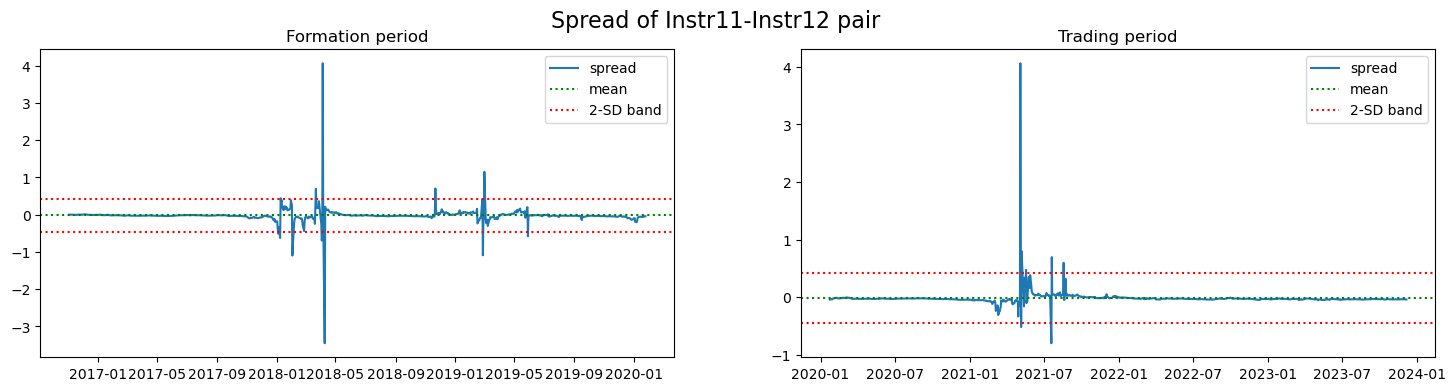

In [34]:
plot_pairs(sorted_distances24_6, train24_6, test24_6)

In [35]:
calculate_metrics(sorted_distances24_6, train24_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
Instr13-Instr14,5.057662,0.0,0.0,0.175447,56,0.403048,0.853875,97.596154
Instr16-Instr17,5.86855,0.000001,0.0,0.203372,54,0.36155,0.814825,96.754808
Instr10-Instr11,6.128322,0.000001,0.0,0.211342,40,0.399002,0.751099,98.4375
Instr12-Instr13,6.196635,0.0,0.0,0.21468,38,0.43591,0.866241,97.836538
Instr11-Instr12,6.307296,0.0,0.0,0.217755,36,0.417352,0.702028,98.317308


In [36]:
calculate_metrics(sorted_distances24_6, test24_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
Instr13-Instr14,7.323764,0.0,0.0,0.230962,18,0.388102,0.733533,99.2
Instr16-Instr17,11.787452,0.0,0.0,0.371562,24,0.44653,0.72009,99.1
Instr10-Instr11,3.855939,0.0,0.0,0.118987,28,0.40016,0.683825,98.3
Instr12-Instr13,5.119545,0.000001,0.000346,0.160464,26,0.379024,0.565157,98.8
Instr11-Instr12,4.772735,0.000004,0.000012,0.149802,22,0.40965,0.837104,98.4
